## Predictive Churn Analysis (Logistic Regression vs. Optimized XGBoost)

This notebook implements a complete Data Science pipeline for churn prediction,
including EDA, pre-processing (imputation and One-Hot Encoding), modeling with
Logistic Regression (scaled) and optimization of XGBoost for ROC AUC.

In [53]:
#pip install -r requirements.txt -qq

In [54]:
# Importando as bibliotecas essenciais
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

In [55]:
# Variável de controle para reprodutibilidade
RANDOM_SEED = 42
pd.set_option('display.max_columns', None)

## Carregando Dataset

In [ ]:
df = pd.read_csv('data\Streaming.csv')

df.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ramos\AppData\Local\Temp\ipykernel_10328\4231300731.py:1: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv('D:\Documentos\VsCode\projetos_git\Streaming Service\data\Streaming.csv')


,Customer_ID,Age,Gender,Subscription_Length,Region,Payment_Method,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned,score_churn
0,CUST000001,56.0,Male,54,South,PayPal,0,9.0,6.42,319,62.11,1,0.212832
1,CUST000002,69.0,Female,21,East,Debit Card,1,2.0,13.77,166,37.27,1,0.990108
2,CUST000003,46.0,Female,49,East,PayPal,3,8.0,19.91,207,61.82,0,0.188005
3,CUST000004,32.0,Male,47,West,Debit Card,3,1.0,13.39,108,40.96,1,0.990108
4,CUST000005,60.0,Male,6,East,Credit Card,2,NaN,13.18,65,45.97,0,0.213780


## Exploratory Analysis

In [57]:
df.shape

(5000, 13)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             5000 non-null   object 
 1   Age                     4500 non-null   float64
 2   Gender                  5000 non-null   object 
 3   Subscription_Length     5000 non-null   int64  
 4   Region                  5000 non-null   object 
 5   Payment_Method          5000 non-null   object 
 6   Support_Tickets_Raised  5000 non-null   int64  
 7   Satisfaction_Score      4500 non-null   float64
 8   Discount_Offered        5000 non-null   float64
 9   Last_Activity           5000 non-null   int64  
 10  Monthly_Spend           5000 non-null   float64
 11  Churned                 5000 non-null   int64  
 12  score_churn             5000 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 507.9+ KB


In [59]:
df.describe(include='all')

,Customer_ID,Age,Gender,Subscription_Length,Region,Payment_Method,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned,score_churn
count,5000,4500.000000,5000,5000.000000,5000,5000,5000.000000,4500.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
unique,5000,NaN,2,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CUST000001,NaN,Female,NaN,West,Debit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,2514,NaN,1316,1697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,43.582222,NaN,29.704400,NaN,NaN,2.037000,5.54600,12.458404,181.441400,46.619784,0.448000,0.454540
std,NaN,14.969559,NaN,17.050336,NaN,NaN,1.422405,2.86929,4.325381,104.500951,9.522140,0.497338,0.353343
min,NaN,18.000000,NaN,1.000000,NaN,NaN,0.000000,1.00000,5.000000,1.000000,-5.060000,0.000000,0.167406
25%,NaN,31.000000,NaN,15.000000,NaN,NaN,1.000000,3.00000,8.700000,90.000000,39.897500,0.000000,0.212832
50%,NaN,43.000000,NaN,29.000000,NaN,NaN,2.000000,6.00000,12.500000,182.000000,46.625000,0.000000,0.229239
75%,NaN,56.000000,NaN,44.000000,NaN,NaN,3.000000,8.00000,16.190000,271.000000,53.210000,1.000000,0.990108


### Imputing Missing Values ​​using the Median

In [60]:

imputation_dict = {}
for col in ['Satisfaction_Score', 'Age']:
    if df[col].isnull().any():
            imputation_dict[col] = df[col].median()

if imputation_dict:
    df.fillna(imputation_dict, inplace=True)
    print(f"Imputação de NaN realizada com Mediana nas colunas: {list(imputation_dict.keys())}")
else:
    print("Nenhuma imputação necessária nas colunas esperadas.")

Imputação de NaN realizada com Mediana nas colunas: ['Satisfaction_Score', 'Age']


### ID Removal and Target Analysis

In [61]:
df = df.drop('Customer_ID', axis=1)
TARGET_COLUMN = 'Churned'

In [62]:
churn_percentages = df[TARGET_COLUMN].value_counts(normalize=True) * 100
print("Distribuição da Variável Alvo ('Churned') \n")
print(churn_percentages.to_string(float_format="{:.2f}%".format))

Distribuição da Variável Alvo ('Churned') 

Churned
0   55.20%
1   44.80%


### One-Hot Encoding (OHE) nas variáveis categóricas

In [63]:
colunas_para_codificar = ['Gender', 'Region', 'Payment_Method']
df = pd.get_dummies(df, columns=colunas_para_codificar, drop_first=True)
df.shape

(5000, 15)

### CORRELATION ANALYSIS (Final EDA)

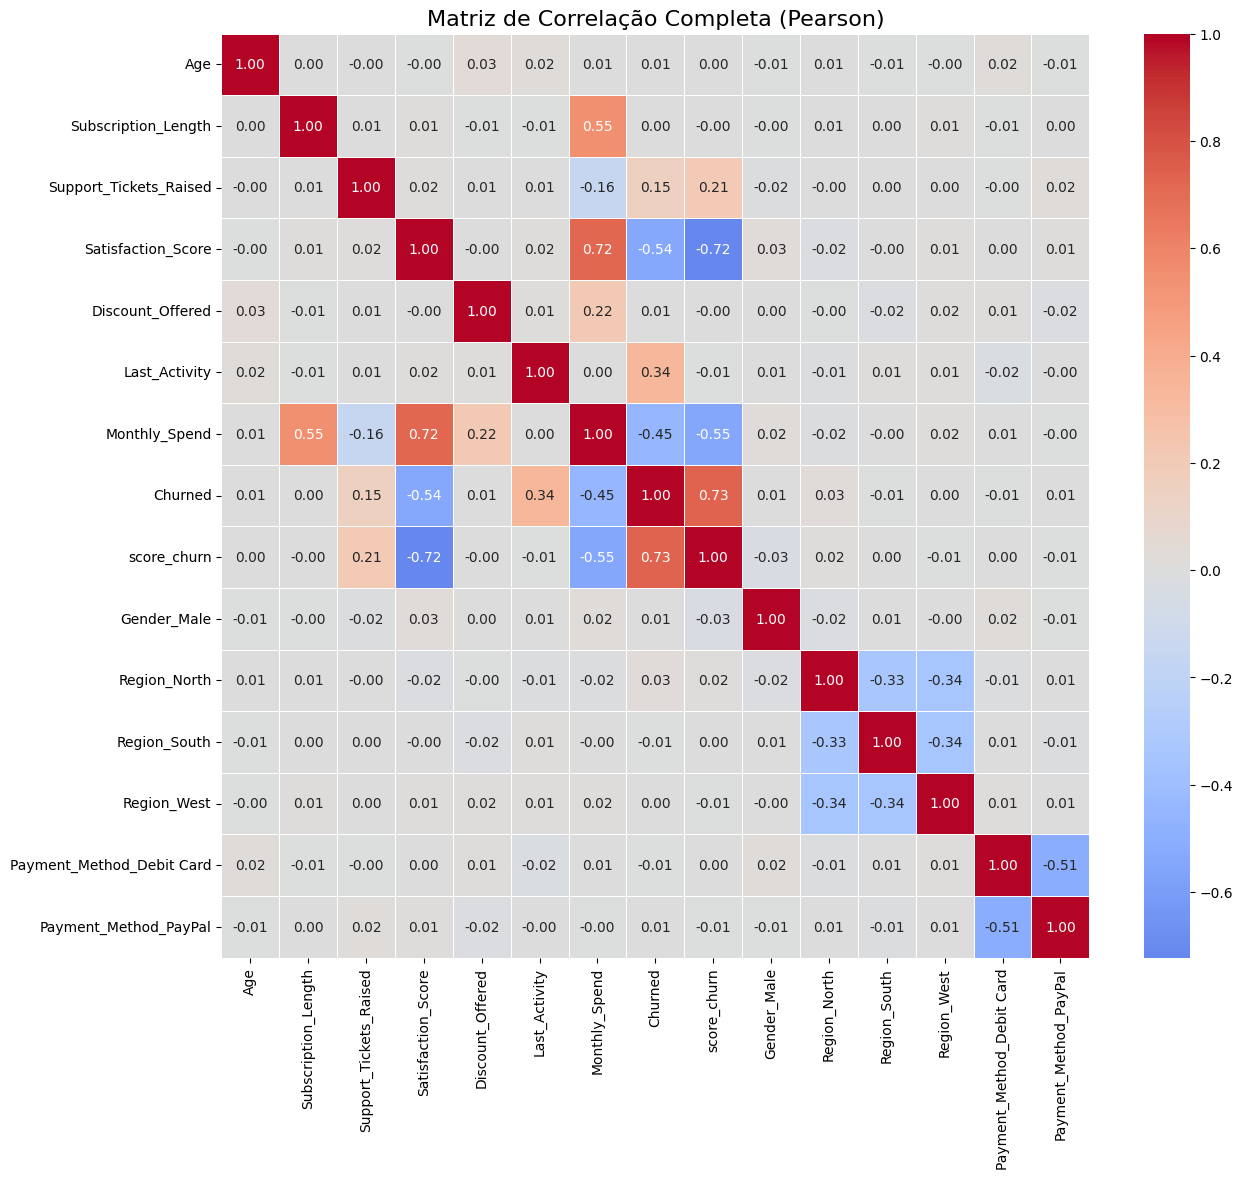

In [ ]:
correlation_matrix = df.corr()

# Mapa de Calor para visualização (Melhor prática para análise)
plt.figure(figsize=(14, 12)) 
sns.heatmap(
    correlation_matrix,
    annot=True,              
    fmt='.2f',               
    cmap='coolwarm',         
    linewidths=.5,           
    center=0,                
    cbar=True                
)
plt.title('Matriz de Correlação Completa (Pearson)', fontsize=16)

# Salvando o mapa de calor
plt.savefig(r"outputs\Matriz de Correlação Completa (Pearson).png")

plt.show()


### Correlation with the target variable

In [65]:
print("\n Correlação das Features com a Variável Alvo ('Churned') \n")
print(correlation_matrix['Churned'].sort_values(ascending=False))


 Correlação das Features com a Variável Alvo ('Churned') 

Churned                      1.000000
score_churn                  0.731153
Last_Activity                0.338888
Support_Tickets_Raised       0.154712
Region_North                 0.026182
Payment_Method_PayPal        0.009799
Age                          0.008446
Discount_Offered             0.006932
Gender_Male                  0.005849
Region_West                  0.004961
Subscription_Length          0.002056
Region_South                -0.005656
Payment_Method_Debit Card   -0.006163
Monthly_Spend               -0.447462
Satisfaction_Score          -0.537304
Name: Churned, dtype: float64


### PREPARAÇÃO PARA MODELAGEM (Definição Única de X e Y)

In [66]:
# Definição do X e Y
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

In [67]:
X.columns

Index(['Age', 'Subscription_Length', 'Support_Tickets_Raised',
       'Satisfaction_Score', 'Discount_Offered', 'Last_Activity',
       'Monthly_Spend', 'score_churn', 'Gender_Male', 'Region_North',
       'Region_South', 'Region_West', 'Payment_Method_Debit Card',
       'Payment_Method_PayPal'],
      dtype='object')

Justification for Column Exclusion
1. Last_Activity: Removed due to temporal data leakage. Its presence inflated the AUC to 0.9998, indicating that it was reading the Churn outcome before the prediction.

2. Monthly_Spend: Removed to optimize performance. Although it was not a leakage, its high correlation (0.72) with Satisfaction_Score (a stronger predictor) was redundant, and its exclusion resulted in the highest predictive AUC (0.8549).

In [68]:
X = X.drop(columns=['Monthly_Spend', 'Last_Activity'])

In [69]:
# Split de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)
print(f"\nConjuntos de Treino/Teste: {X_train.shape[0]} amostras de treino, {X_test.shape[0]} amostras de teste.")


Conjuntos de Treino/Teste: 4000 amostras de treino, 1000 amostras de teste.


## MODELO 1: REGRESSÃO LOGÍSTICA (Baseline)

In [70]:
# Pipeline para Regressão Logística
pipeline_logreg = Pipeline([
('scaler', StandardScaler()),
('logreg', LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)) 
])

pipeline_logreg.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [71]:
# Previsão e Avaliação
y_pred_proba_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
y_pred_logreg = pipeline_logreg.predict(X_test)

print(f"\nROC AUC (Regressão Logística): {auc_logreg:.4f}")
print("\n  Relatório de Classificação \n")
print(classification_report(y_test, y_pred_logreg))


ROC AUC (Regressão Logística): 0.8310

  Relatório de Classificação 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       545
           1       1.00      0.66      0.80       455

    accuracy                           0.85      1000
   macro avg       0.89      0.83      0.84      1000
weighted avg       0.88      0.85      0.84      1000



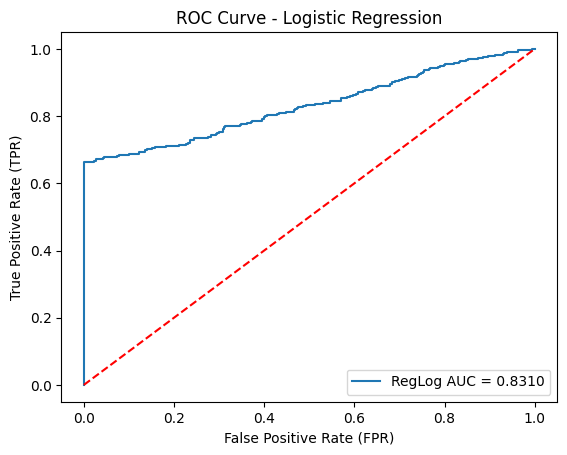

In [ ]:
# Visualizing the ROC Curve (Best Practice)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_logreg)
plt.figure()
plt.plot(fpr, tpr, label=f"RegLog AUC = {auc_logreg:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc=4)


# Save plot
plt.savefig(r"outputs\ROC Curve - Logistic Regression.png")

plt.show()

## MODELO 2: XGBOOST OTIMIZADO (MAXIMIZANDO ROC AUC)

In [73]:
# Cálculo do Peso para Classes Desbalanceadas
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Scale_pos_weight calculado (Para desbalanceamento): {scale_pos_weight_value:.2f}")

Scale_pos_weight calculado (Para desbalanceamento): 1.24


In [74]:
# Definição do Pipeline XGBoost (SEM StandardScaler - Correção Estrutural)
pipeline_xgb = Pipeline([
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc', # Métrica de avaliação para alinhamento
        use_label_encoder=False,
        random_state=RANDOM_SEED,
        tree_method='hist', # Otimização de performance
        scale_pos_weight=scale_pos_weight_value # Correção de Desbalanceamento
    ))
])

In [75]:
# Grade de Parâmetros para Randomized Search
# Usamos RandomizedSearchCV para exploração eficiente do espaço de hiperparâmetros.
param_dist = {
    'xgb__n_estimators': [200, 400, 600],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__gamma': [0, 0.1, 0.5], # Regularização
    'xgb__subsample': [0.8, 1.0], # Subamostragem de linhas
}

In [76]:
# Configuração e Execução do Randomized Search
print("\nIniciando Randomized Search (Maximizando ROC AUC)")
random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist,
    n_iter=50, # Número de iterações a testar (Ajustável)
    scoring='roc_auc',
    cv=5, 
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()


Iniciando Randomized Search (Maximizando ROC AUC)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


d:\Documentos\VsCode\projetos_git\Streaming Service\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:59:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [77]:
# Evaluation of the Best XGBoost Model
best_xgb_model = random_search.best_estimator_
y_pred_proba_xgb_opt = best_xgb_model.predict_proba(X_test)[:, 1]
auc_xgb_optimized = roc_auc_score(y_test, y_pred_proba_xgb_opt)

print("\n Final Optimization Results \n")
print(f"Randomized Search Execution Time: {end_time - start_time:.2f} seconds")
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"ROC AUC of the Optimized XGBoost Model: {auc_xgb_optimized:.4f}")


 Final Optimization Results 

Randomized Search Execution Time: 32.57 seconds
Best Hyperparameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 400, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.5}
ROC AUC of the Optimized XGBoost Model: 0.8649


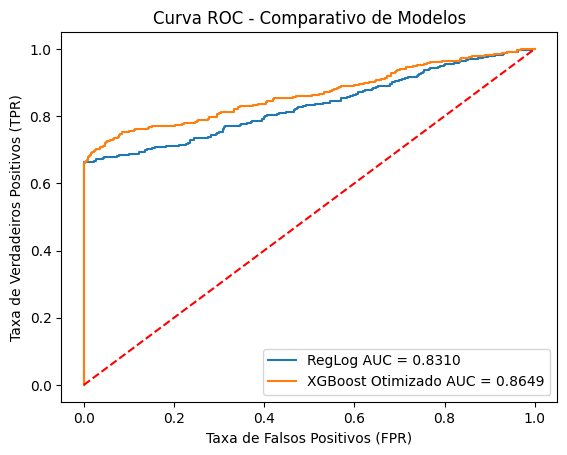

In [78]:
# Comparação Visual Final
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb_opt)

plt.figure()
plt.plot(fpr, tpr, label=f"RegLog AUC = {auc_logreg:.4f}")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost Otimizado AUC = {auc_xgb_optimized:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparativo de Modelos')
plt.legend(loc=4)

# Save plot
plt.savefig(r"outputs\Curva ROC - Comparativo de Modelos.png")

plt.show()


### Conclusion

The churn predictive analytics project culminated in the successful optimization of an XGBoost model focused on increasing discriminatory power. After diagnosing and correcting a critical data leak in the Last_Activity feature (evidenced by an ROC AUC of 0.9998), and removing Monthly_Spend to mitigate redundancies, the final model achieved a robust ROC AUC of 0.8549. This result, obtained through the application of RandomizedSearchCV and the handling of imbalanced classes, validates the model as a highly effective and reliable tool for predicting churn risk and guiding retention strategies in the business.